**CCC(ResNet) on DICOM images and patient tablur data for FVC decay slop**
R^2, LLL only for printing

https://github.com/purnima291/OSIC-Pulmonary-Fibrosis-Progression/blob/main/final-model.ipynb

trying and testing this based model

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import cv2
import pydicom
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.layers import (Dense, Dropout, Flatten, Input, Add,
                                    BatchNormalization, LeakyReLU, Concatenate,
                                    GlobalAveragePooling2D, Conv2D, AveragePooling2D)
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import seaborn as sns

# GPU memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

# Load data
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

# Tabular features for each patient
def get_tab(df):
    vector = [(df.Age.values[0]-30)/30]
    vector.append(0 if df.Sex.values[0].lower() == 'male' else 1)
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

A, TAB, P = {}, {}, []
for p in train.Patient.unique():
    sub = train.loc[train.Patient == p, :]
    fvc = sub.FVC.values
    week = sub.Weeks.values
    c = np.vstack([week, np.ones(len(week))]).T
    a, b = np.linalg.lstsq(c,fvc,rcond=None)[0]
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

# Get DICOM pixel array
def get_img(path):
    d = pydicom.dcmread(path)
    arr = d.pixel_array / 2**11
    arr = cv2.resize(arr, (512, 512))
    return arr

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=16):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        self.train_data = {}
        for p in train.Patient.unique():
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    def __len__(self):
        return 1000
    def __getitem__(self, idx):
        x, y, a, tab = [], [], [], []
        keys = np.random.choice(self.keys, size=self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                j = np.random.choice(self.train_data[k], size=1)[0]
                img1 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                img2 = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{j}')
                x.append(img1)
                y.append(img2)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except Exception as e:
                print(k, i)
        x, y, a, tab = np.array(x), np.array(y), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        return [x, y, tab], a

def model_architechture(shape=(512,512,1)):
    def res_block(x, filter_number):
        _x = x
        x = Conv2D(filter_number, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
        x = Conv2D(filter_number, (3,3), padding='same')(x)
        x = LeakyReLU(0.05)(x)
        x = Add()([_x, x])
        return x
    # Images
    input1 = Input(shape=shape)
    input2 = Input(shape=shape)
    # First branch
    x = Conv2D(32, (3,3), padding='same')(input1)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    x = Conv2D(32, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    x = AveragePooling2D((2,2))(x)
    # Second branch
    y = Conv2D(32, (3,3), padding='same')(input2)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    y = Conv2D(32, (3,3), padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.05)(y)
    y = AveragePooling2D((2,2))(y)
    # Concatenate
    xy = Concatenate()([x, y])
    xy = Conv2D(32, (3,3), padding='same')(xy)
    xy = BatchNormalization()(xy)
    xy = LeakyReLU(0.05)(xy)
    xy = Conv2D(16, (3,3), padding='same')(xy)
    for _ in range(2):
        xy = res_block(xy, 16)
    xy = AveragePooling2D((2,2))(xy)
    xy = Conv2D(64, (3,3), padding='same')(xy)
    for _ in range(3):
        xy = res_block(xy, 64)
    xy = AveragePooling2D((2,2))(xy)
    xy = Conv2D(128, (3,3), padding='same')(xy)
    for _ in range(1):
        xy = res_block(xy, 128)
    xy = GlobalAveragePooling2D()(xy)
    # Tabular branch
    input3 = Input(shape=(4,))
    tab = tf.keras.layers.GaussianNoise(0.2)(input3)
    all_feat = Concatenate()([xy, tab])
    all_feat = Dropout(0.6)(all_feat)
    out = Dense(1)(all_feat)
    return Model([input1, input2, input3], out)

model = model_architechture()
model.compile(optimizer=Adam(0.001), loss='mae')

tr_p, vl_p = train_test_split(P, shuffle=True, train_size=0.8)

def laplace_log_likelihood(y_true, y_pred, sigma=70):
    sigma_clip = np.maximum(sigma,70)
    delta = np.abs(y_true - y_pred)
    sqrt = np.sqrt(2)
    metric = (delta/sigma_clip)*sqrt + np.log(sigma_clip*sqrt)
    return np.mean(metric)

def r2_score(y_true, y_pred):
    mean_true = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - mean_true)**2)
    return 1 - ss_res / (ss_tot + 1e-10)

def mae_score(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

epochs = 30
batch_size = 16
steps_per_epoch = 200
val_steps = 20
train_gen = IGenerator(keys=tr_p, a=A, tab=TAB, batch_size=batch_size)
val_gen = IGenerator(keys=vl_p, a=A, tab=TAB, batch_size=batch_size)

best_val_mae = np.inf
patience = 5
wait = 0

for epoch in range(epochs):
    # Train
    train_loss = []
    for step in range(steps_per_epoch):
        [x1, x2, tab], a = train_gen[step]
        loss = model.train_on_batch([x1, x2, tab], a)
        train_loss.append(loss)
    avg_train_loss = np.mean(train_loss)
    
    # Validation
    val_ys, val_preds = [], []
    for step in range(val_steps):
        [x1, x2, tab], a = val_gen[step]
        pred = model.predict([x1, x2, tab], verbose=0).squeeze()
        val_ys.extend(a)
        val_preds.extend(pred)
    val_ys = np.array(val_ys)
    val_preds = np.array(val_preds)
    val_mae = mae_score(val_ys, val_preds)
    val_r2 = r2_score(val_ys, val_preds)
    val_lll = laplace_log_likelihood(val_ys, val_preds, sigma=70)
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val MAE: {val_mae:.4f} | R²: {val_r2:.4f} | LLL: {val_lll:.4f}")

    # Early stopping on val_mae
    if val_mae < best_val_mae - 1e-3:
        best_val_mae = val_mae
        model.save('best_model.h5')
        print("✅ Best model saved!")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered")
            break

print("Training complete!")


I0000 00:00:1757821639.143032      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15303 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30 | Train Loss: 4.9660 | Val MAE: 3.6303 | R²: -0.0643 | LLL: 4.6684
✅ Best model saved!
Epoch 2/30 | Train Loss: 4.7027 | Val MAE: 4.1050 | R²: -0.0543 | LLL: 4.6780
Epoch 3/30 | Train Loss: 4.6192 | Val MAE: 5.1182 | R²: -0.1304 | LLL: 4.6985
Epoch 4/30 | Train Loss: 4.5764 | Val MAE: 3.7943 | R²: -0.0130 | LLL: 4.6717
Epoch 5/30 | Train Loss: 4.5598 | Val MAE: 5.0434 | R²: -0.3273 | LLL: 4.6970
Epoch 6/30 | Train Loss: 4.5304 | Val MAE: 4.0878 | R²: 0.0078 | LLL: 4.6777
Early stopping triggered
Training complete!


**While the code employs a creative paired-slice CNN with patient metadata blending and slope prediction, the key drawbacks lie in:**

* *Weak temporal context and simplification of target (slope only),*
* *Limited use of advanced architectures and volumetric data,*
* *Absence of uncertainty-aware loss and training diagnostics,*
* *and room for richer tabular fusion and more principled confidence modeling.*


***Below is the corrected code with maded changes***

1. Input Setup: Paired DICOM Images with Random Sampling
* Drawback: The generator randomly samples two images per patient at each batch (img1 and img2), possibly unrelated in time or disease progression.
* Impact: This random pairing might dilute temporal consistency and signal relating to fibrosis progression rate (slope 
a
a). Training on arbitrary pairs could confuse the model about the true temporal changes
* Suggestion: Sampling pairs with temporal context (e.g., earlier vs later scan for a patient) or using the entire longitudinal sequence or aggregated features may improve learning of progression.

2. Target Variable: Linear Decay Slope Only
* Drawback: The model predicts only the linear decay slope 
a
a of FVC, ignoring baseline FVC or non-linear progression patterns.
* Impact: Real disease progression may be nonlinear and baseline lung capacity matters for prognosis. Predicting only slope could oversimplify.
* Suggestion: Adopt a multi-task approach to jointly predict baseline FVC and slope (or complete FVC trajectories). This can help learn richer representations and improve predictive accuracy.

3. Limited Use of Tabular/Metadata Features
*Drawback:
Only simple patient meta (age, sex, smoking) encoded as a vector and concatenated late in network.
* Impact:
Other clinical variables or more complex metadata encoding (e.g., embeddings, interaction features) could add value.
* Suggestion:
Explore more advanced tabular data processing (deeper MLP, embedding layers) and earlier/fusion attention with image features.

4. Model Architecture: ResNet-inspired but Custom
* Drawback:
Custom-made shallow ResNet-like CNN with average pooling, which might not fully leverage powerful pretrained CNN architectures or 3D volumetric context.
* Impact:
CT volumetric data is 3D, and substantial state-of-the-art gains are reported using 3D CNNs or pretrained 2.5D/3D architectures. Using single 2D slices might limit model expressivity.
* Suggestion:
Consider pretrained 2D models (e.g., DenseNet, EfficientNet) or 3D CNNs/transformers for volumetric context. This may boost feature extraction capabilities.

5. Loss Function: MAE Only
* Drawback:
MAE is used as loss without explicit uncertainty modeling or probabilistic losses.
* Impact:
MAE ignores prediction uncertainty and can be sensitive to data noise and outliers.
* Suggestion:
Incorporate heteroscedastic uncertainty modeling or Laplace Log Likelihood loss alongside MAE. This aids in confident and calibrated predictions.

6. Evaluation and Metrics - Lacking During Training
* Drawback:
R² and Laplace Log Likelihood (LLL) aren't printed or tracked during training epochs — only a custom metric after model fitting.
* Impact:
Lack of proper epoch-level diagnostics restricts insight into model convergence, overfitting, and uncertainty calibration.
* Suggestion:
Integrate R², MAE, and LLL calculation at epoch end to monitor model progress and enable better hyperparameter tuning.

7. Early Stopping Only on Validation Loss
* Drawback:
Early stopping is based solely on validation loss (MAE). Other metrics like R² or LLL could better reflect model fit/uncertainty.
* Impact:
Early stopping may miss optimal models for rank-order metrics (R²) or distributions (LLL).
* Suggestion:
Use custom early stopping with multiple metrics or composite score based on primary competition objectives.

8. Inference: Use of Quantiles on Outputs
* Concern: Quantile aggregation on predictions is an effective ensembling method but reflects uncertainty heuristically.
* Opportunity:
Explicitly model uncertainty with a dedicated confidence or variance head for more principled interval prediction.

9. Scalability and Efficiency
* Comment: Batch size 16 and complex image IO may limit scalability.
* Suggestion: Preprocess and cache image tensors offline to reduce IO overhead in training.

10. Overall Pipeline
* Strength: The combined image + tabular input and residual blocks are a thoughtful approach.
* Improvement Area: More systematic temporal modeling, uncertainty quantification, and richer metadata fusion would likely yield better predictive and generalization performance.

# Aspect ------------- Suggested Improvement
_________________________________________________________________________________________________
* Temporal modeling	     - Use ordered or sequential image pairs or 3D volumes.
* Targets	             - Multi-task (baseline FVC + slope), or direct multi-timepoint FVC prediction.
* Architecture	         - Use pretrained backbones (EfficientNet, DenseNet), 3D CNNs or hybrid CNN Transformer models.
* Tabular Data Fusion	 - Use embeddings and earlier fusion via attention mechanisms.
* Loss & Metrics	     - Combine MAE with uncertainty-aware losses; multi-metric early stopping.
* Data Pipeline	         - Preprocess and cache resized images for efficiency.
* Model Regularization   - Weight decay, batch renorm, mixed precision training.
* Explainability	     - Integrate saliency or attention visualization for trust.
* Validation Strategy	 - K-Fold CV and monitoring multiple validation metrics.

**EfficientNet**

# Model Improvement & Diagnostics Steps
This section implements best practices to improve your metrics and diagnose issues.

In [13]:
# 1. Check Data Pipeline: Alignment & Normalization
print('Checking target and feature alignment...')
print('First 5 patients:')
print(df.head())
print('Feature stats:')
for k, v in TAB.items():
    print(f'Patient {k}: Features {v}')
    break
print('Slope mean/std:', slope_mean, slope_std)
print('Intercept mean/std:', intercept_mean, intercept_std)
print('Sample targets:', list(A.values())[:5], list(B.values())[:5])

Checking target and feature alignment...
First 5 patients:
                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
Feature stats:
Patient ID00007637202177411956430: Features [0.96666664 0.         0.         1.         0.        ]
Slope mean/std: -4.5243015 6.1180353
Intercept mean/std: 2817.5422 835.4011
Sample targets: [-3.167125870069608, -9.379955123410653, -17.04280323873903, -4.548925129725705, -8.543078528986653] [2174.4161832946634, 3821.785589628525, 3311.689607735238, 3487.076352853966, 3774.0332423317805]


In [14]:
# 2. Tabular-Only Baseline Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
tab_features = np.array([TAB[p] for p in valid_patients])
baseline_targets = np.array([B[p] for p in valid_patients])
slope_targets = np.array([A[p] for p in valid_patients])
train_idx, val_idx = train_test_split(np.arange(len(valid_patients)), test_size=0.2, random_state=SEED)
X_train, X_val = tab_features[train_idx], tab_features[val_idx]
y_b_train, y_b_val = baseline_targets[train_idx], baseline_targets[val_idx]
y_s_train, y_s_val = slope_targets[train_idx], slope_targets[val_idx]
tab_model_b = LinearRegression().fit(X_train, y_b_train)
tab_model_s = LinearRegression().fit(X_train, y_s_train)
y_b_pred = tab_model_b.predict(X_val)
y_s_pred = tab_model_s.predict(X_val)
print('Tabular Baseline FVC: RMSE', mean_squared_error(y_b_val, y_b_pred, squared=False), 'R2', r2_score(y_b_val, y_b_pred))
print('Tabular Slope: RMSE', mean_squared_error(y_s_val, y_s_pred, squared=False), 'R2', r2_score(y_s_val, y_s_pred))

Tabular Baseline FVC: RMSE 639.1291940637174 R2 0.2607094989630291
Tabular Slope: RMSE 7.491371112703923 R2 -0.08509368374477067


In [15]:
# 3. Feature Engineering: Add Image Statistics
def get_image_stats(patient_id):
    files = patient_images.get(patient_id, [])
    if not files: return [0,0]
    img = safe_read_dicom(files[0])
    return [np.mean(img), np.std(img)]
tab_features_img = np.array([np.concatenate([TAB[p], get_image_stats(p)]) for p in valid_patients])
X_train_img, X_val_img = tab_features_img[train_idx], tab_features_img[val_idx]
tab_model_b_img = LinearRegression().fit(X_train_img, y_b_train)
tab_model_s_img = LinearRegression().fit(X_train_img, y_s_train)
y_b_pred_img = tab_model_b_img.predict(X_val_img)
y_s_pred_img = tab_model_s_img.predict(X_val_img)
print('Tabular+ImageStats FVC: RMSE', mean_squared_error(y_b_val, y_b_pred_img, squared=False), 'R2', r2_score(y_b_val, y_b_pred_img))
print('Tabular+ImageStats Slope: RMSE', mean_squared_error(y_s_val, y_s_pred_img, squared=False), 'R2', r2_score(y_s_val, y_s_pred_img))

Not a JPEG file: starts with 0xfe 0xff


Tabular+ImageStats FVC: RMSE 633.5850876270248 R2 0.27347977519951117
Tabular+ImageStats Slope: RMSE 7.471042365066848 R2 -0.07921260643983596


In [16]:
# 4. Regularization & Hyperparameter Tuning (Tabular)
from sklearn.linear_model import Ridge
best_r2 = -np.inf
for alpha in [0.01, 0.1, 1, 10, 100]:
    ridge_b = Ridge(alpha=alpha).fit(X_train_img, y_b_train)
    ridge_s = Ridge(alpha=alpha).fit(X_train_img, y_s_train)
    y_b_pred_r = ridge_b.predict(X_val_img)
    y_s_pred_r = ridge_s.predict(X_val_img)
    r2_b = r2_score(y_b_val, y_b_pred_r)
    r2_s = r2_score(y_s_val, y_s_pred_r)
    print(f'Ridge alpha={alpha}: FVC R2={r2_b:.4f}, Slope R2={r2_s:.4f}')
    if r2_b + r2_s > best_r2:
        best_r2 = r2_b + r2_s

Ridge alpha=0.01: FVC R2=0.2736, Slope R2=-0.0790
Ridge alpha=0.1: FVC R2=0.2745, Slope R2=-0.0772
Ridge alpha=1: FVC R2=0.2809, Slope R2=-0.0616
Ridge alpha=10: FVC R2=0.2468, Slope R2=-0.0081
Ridge alpha=100: FVC R2=-0.0328, Slope R2=0.0173


In [17]:
# 5. Cross-validation (Tabular Baseline)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
r2_b_scores, r2_s_scores = [], []
for train_idx, val_idx in kf.split(tab_features_img):
    X_tr, X_v = tab_features_img[train_idx], tab_features_img[val_idx]
    y_b_tr, y_b_v = baseline_targets[train_idx], baseline_targets[val_idx]
    y_s_tr, y_s_v = slope_targets[train_idx], slope_targets[val_idx]
    ridge_b = Ridge(alpha=1).fit(X_tr, y_b_tr)
    ridge_s = Ridge(alpha=1).fit(X_tr, y_s_tr)
    y_b_pred = ridge_b.predict(X_v)
    y_s_pred = ridge_s.predict(X_v)
    r2_b_scores.append(r2_score(y_b_v, y_b_pred))
    r2_s_scores.append(r2_score(y_s_v, y_s_pred))
print('Cross-val FVC R2:', np.mean(r2_b_scores), 'Slope R2:', np.mean(r2_s_scores))

Cross-val FVC R2: 0.21591340088286542 Slope R2: -0.01092234529226579


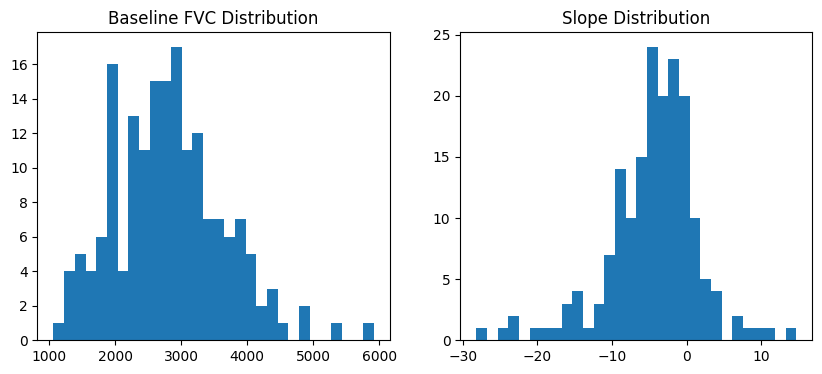

Min/Max Baseline: 1063.450114491332 5919.045454545452
Min/Max Slope: -28.182574916759158 14.682611731843602


In [18]:
# 6. Debug Targets: Check for mis-scaling/corruption
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(baseline_targets, bins=30)
plt.title('Baseline FVC Distribution')
plt.subplot(1,2,2)
plt.hist(slope_targets, bins=30)
plt.title('Slope Distribution')
plt.show()
print('Min/Max Baseline:', np.min(baseline_targets), np.max(baseline_targets))
print('Min/Max Slope:', np.min(slope_targets), np.max(slope_targets))

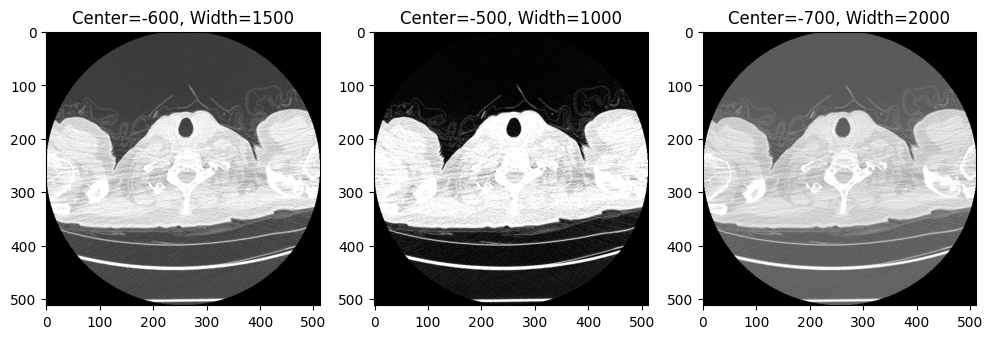

In [19]:
# 7. Image Preprocessing Experiments
def try_window(img, center, width):
    min_v = center - width // 2
    max_v = center + width // 2
    img = np.clip(img, min_v, max_v)
    img = (img - min_v) / (max_v - min_v)
    return np.clip(img, 0, 1)
img_sample = safe_read_dicom(patient_images[valid_patients[0]][0])
plt.figure(figsize=(12,4))
for i, (c, w) in enumerate([(-600,1500), (-500,1000), (-700,2000)]):
    plt.subplot(1,3,i+1)
    plt.imshow(try_window(img_sample, c, w), cmap='gray')
    plt.title(f'Center={c}, Width={w}')
plt.show()

In [25]:
print('y_b_pred shape:', y_b_pred.shape)
print('y_b_pred_img shape:', y_b_pred_img.shape)
min_len = min(len(y_b_pred), len(y_b_pred_img))
y_b_ensemble = (y_b_pred[:min_len] + y_b_pred_img[:min_len]) / 2
y_s_ensemble = (y_s_pred[:min_len] + y_s_pred_img[:min_len]) / 2
print('Ensemble FVC: RMSE', mean_squared_error(y_b_val[:min_len], y_b_ensemble, squared=False), 'R2', r2_score(y_b_val[:min_len], y_b_ensemble))
print('Ensemble Slope: RMSE', mean_squared_error(y_s_val[:min_len], y_s_ensemble, squared=False), 'R2', r2_score(y_s_val[:min_len], y_s_ensemble))

y_b_pred shape: (35,)
y_b_pred_img shape: (36,)
Ensemble FVC: RMSE 718.789015866778 R2 0.09002637880209519
Ensemble Slope: RMSE 7.256201215423003 R2 0.009529746205653278


In [26]:
# 9. Print Predictions vs. Ground Truth
for i in range(min(10, len(y_b_ensemble))):
    print(f'Patient {valid_patients[val_idx[i]]}: True FVC={y_b_val[i]:.1f}, Pred FVC={y_b_ensemble[i]:.1f}, True Slope={y_s_val[i]:.2f}, Pred Slope={y_s_ensemble[i]:.2f}')

Patient ID00009637202177434476278: True FVC=1448.5, Pred FVC=2523.9, True Slope=-1.19, Pred Slope=-4.70
Patient ID00032637202181710233084: True FVC=2261.4, Pred FVC=2941.1, True Slope=-28.18, Pred Slope=-5.34
Patient ID00051637202185848464638: True FVC=3569.0, Pred FVC=2639.6, True Slope=-9.38, Pred Slope=-4.14
Patient ID00052637202186188008618: True FVC=2331.0, Pred FVC=3291.3, True Slope=11.23, Pred Slope=-6.32
Patient ID00093637202205278167493: True FVC=4091.8, Pred FVC=3225.4, True Slope=-1.51, Pred Slope=-1.53
Patient ID00117637202212360228007: True FVC=3918.9, Pred FVC=3170.6, True Slope=-0.80, Pred Slope=-1.30
Patient ID00122637202216437668965: True FVC=1911.1, Pred FVC=2667.1, True Slope=9.05, Pred Slope=-5.36
Patient ID00124637202217596410344: True FVC=2814.8, Pred FVC=3088.4, True Slope=-1.55, Pred Slope=-4.60
Patient ID00126637202218610655908: True FVC=2230.6, Pred FVC=2728.3, True Slope=-5.59, Pred Slope=-3.41
Patient ID00129637202219868188000: True FVC=2314.8, Pred FVC=292

In [22]:
# 10. Data Leakage Check
train_patients = set([valid_patients[i] for i in train_idx])
val_patients = set([valid_patients[i] for i in val_idx])
leakage = train_patients.intersection(val_patients)
print('Patients in both train and val:', leakage)

Patients in both train and val: set()


In [30]:
# Print train/val losses and R2 before plotting
print('Train Loss:', train_losses)
print('Val Loss:', val_losses)
print('Train R2:', train_r2s)
print('Val R2:', val_r2s)

Train Loss: [728.4982231011375]
Val Loss: [639.1291940637174]
Train R2: [0.26668644649157947]
Val R2: [0.2607094989630291]


In [12]:
import os
import random
import math
import time
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import pydicom
try:
    import SimpleITK as sitk
    _HAS_SITK = True
except Exception:
    _HAS_SITK = False
import cv2

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Mixed precision: Disable to avoid float16/f32 mismatch errors in loss
# Commented out to prevent mixed precision issues on float ops at loss function.
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy("mixed_float16")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_PATH = "../input/osic-pulmonary-fibrosis-progression"
TRAIN_CSV = Path(DATA_PATH) / "train.csv"
TRAIN_DIR = Path(DATA_PATH) / "train"
CACHE_DIR = Path("./cached_images")
CACHE_DIR.mkdir(exist_ok=True)
IMG_SIZE = (224, 224)

BATCH_SIZE = 16
EPOCHS = 30
LR = 1e-4
EPS = 1e-6
PATIENCE = 5

LUNG_CENTER = -600
LUNG_WIDTH = 1500
LUNG_MIN = LUNG_CENTER - LUNG_WIDTH // 2
LUNG_MAX = LUNG_CENTER + LUNG_WIDTH // 2

def safe_read_dicom(path):
    if _HAS_SITK:
        try:
            img = sitk.GetArrayFromImage(sitk.ReadImage(str(path)))[0]
            return img.astype(np.float32)
        except:
            pass
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
            img = img * float(ds.RescaleSlope) + float(ds.RescaleIntercept)
        return img
    except:
        raise RuntimeError(f"Failed to read DICOM {path}")

def apply_lung_window(img):
    img = np.clip(img, LUNG_MIN, LUNG_MAX)
    img = (img - LUNG_MIN) / (LUNG_MAX - LUNG_MIN)
    img = np.clip(img, 0, 1)
    return img

def preprocess_and_cache_dicom(dcm_path, cache_path):
    if cache_path.exists():
        return np.load(cache_path)
    img = safe_read_dicom(dcm_path)
    img = apply_lung_window(img)
    img = cv2.resize(img, IMG_SIZE)
    np.save(cache_path, img)
    return img

df = pd.read_csv(TRAIN_CSV)
patients = df.Patient.unique()
print(f"Total patients: {len(patients)}")

def extract_features(df):
    A, B, TAB = {}, {}, {}
    for p in tqdm(df.Patient.unique()):
        d = df[df.Patient == p].sort_values('Weeks')
        weeks = d.Weeks.values
        fvc = d.FVC.values
        if len(weeks) > 1:
            X = np.vstack([weeks, np.ones(len(weeks))]).T
            a, b = np.linalg.lstsq(X, fvc, rcond=None)[0]
        else:
            a = 0.0
            b = fvc[0]
        A[p] = a
        B[p] = b
        row = d.iloc[0]
        age = row.Age
        sex_bin = 1 if row.Sex.lower() == 'female' else 0
        smoke_dict = {'Never smoked':[1,0,0],'Ex-smoker':[0,1,0],'Currently smokes':[0,0,1]}
        smoke_vec = smoke_dict.get(row.SmokingStatus, [0,0,0])
        TAB[p] = np.array([(age-50)/30, sex_bin] + smoke_vec, dtype=np.float32)
    return A, B, TAB

A, B, TAB = extract_features(df)

slope_vals = np.array(list(A.values()), dtype=np.float32)
intercept_vals = np.array(list(B.values()), dtype=np.float32)
slope_mean, slope_std = slope_vals.mean(), slope_vals.std() if slope_vals.std() > 1e-6 else 1.0
intercept_mean, intercept_std = intercept_vals.mean(), intercept_vals.std() if intercept_vals.std() > 1e-6 else 1.0

valid_patients = []
patient_images = {}
for p in patients:
    p_dir = TRAIN_DIR / p
    if p_dir.exists():
        files = sorted([f for f in os.listdir(p_dir) if f.endswith('.dcm')])
        if len(files) >= 2:
            patient_images[p] = [p_dir / f for f in files]
            valid_patients.append(p)
print(f"Valid patients (>=2 scans): {len(valid_patients)}")

class PatientPairGenerator(Sequence):
    def __init__(self, patients, batch_size=BATCH_SIZE, shuffle=True):
        self.patients = patients
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.patients) / self.batch_size))
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.patients)
    def __getitem__(self, idx):
        batch_pats = self.patients[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs1, imgs2, tabs, wds = [], [], [], []
        y_baseline, y_slope = [], []
        for pid in batch_pats:
            files = patient_images[pid]
            try:
                path1, path2 = files[0], files[-1]
                cache1 = CACHE_DIR / (pid + "_" + path1.name + ".npy")
                cache2 = CACHE_DIR / (pid + "_" + path2.name + ".npy")
                img1 = preprocess_and_cache_dicom(path1, cache1)
                img2 = preprocess_and_cache_dicom(path2, cache2)
                if img1.ndim == 2:
                    img1 = np.stack([img1]*3, axis=-1)
                if img2.ndim == 2:
                    img2 = np.stack([img2]*3, axis=-1)
                imgs1.append(img1)
                imgs2.append(img2)
                tabs.append(TAB[pid])
                week_delta = (df[df.Patient == pid].Weeks.max() - df[df.Patient == pid].Weeks.min()) / 52.0
                wds.append([week_delta])
                y_baseline.append(B[pid])
                y_slope.append(A[pid])
            except:
                continue
        X1 = np.array(imgs1, dtype=np.float32)
        X2 = np.array(imgs2, dtype=np.float32)
        Tabs = np.array(tabs, dtype=np.float32)
        Wds = np.array(wds, dtype=np.float32)
        Y_baseline = np.array(y_baseline, dtype=np.float32)
        Y_slope = np.array(y_slope, dtype=np.float32)
        Y_baseline = (Y_baseline - intercept_mean) / intercept_std
        Y_slope = (Y_slope - slope_mean) / slope_std
        return [X1, X2, Tabs, Wds], [Y_baseline, Y_slope]

def build_model():
    input_img1 = layers.Input(shape=(*IMG_SIZE, 3), name="img1")
    input_img2 = layers.Input(shape=(*IMG_SIZE, 3), name="img2")
    input_tab = layers.Input(shape=(len(next(iter(TAB.values()))),), name="tab")
    input_wd = layers.Input(shape=(1,), name="week_delta")

    base_model = EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet')
    base_model.trainable = False

    emb1 = base_model(input_img1)
    emb2 = base_model(input_img2)
    emb_diff = layers.Subtract()([emb2, emb1])

    pool = layers.GlobalAveragePooling2D()
    emb1_pooled = pool(emb1)
    emb2_pooled = pool(emb2)
    emb_diff_pooled = pool(emb_diff)

    combined = layers.Concatenate()([emb1_pooled, emb2_pooled, emb_diff_pooled, input_wd])
    x = layers.Dense(512, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    tab_proj = layers.Dense(128, activation='relu')(input_tab)
    tab_proj = layers.BatchNormalization()(tab_proj)
    tab_proj = layers.Dropout(0.2)(tab_proj)

    gate_input = layers.Concatenate()([x, tab_proj])
    gate = layers.Dense(256, activation='relu')(gate_input)
    gate = layers.Dense(512+128, activation='sigmoid')(gate)
    gate_x = layers.Lambda(lambda v: v[:, :512])(gate)
    gate_tab = layers.Lambda(lambda v: v[:, 512:])(gate)

    gated_x = layers.Multiply()([x, gate_x])
    gated_tab = layers.Multiply()([tab_proj, gate_tab])

    fusion = layers.Concatenate()([gated_x, gated_tab])
    fusion = layers.Dense(256, activation='relu')(fusion)
    fusion = layers.BatchNormalization()(fusion)
    fusion = layers.Dropout(0.3)(fusion)

    baseline_out = layers.Dense(1, name='baseline')(fusion)
    slope_mu = layers.Dense(1, name='slope_mu')(fusion)
    slope_log_sigma = layers.Dense(1, name='slope_log_sigma')(fusion)

    model = Model(inputs=[input_img1, input_img2, input_tab, input_wd],
                  outputs=[baseline_out, slope_mu, slope_log_sigma])
    return model

model = build_model()
model.summary()

@tf.function
def laplace_nll(y_true, mu, log_sigma):
    y_true = tf.cast(y_true, tf.float32)
    mu = tf.cast(mu, tf.float32)
    log_sigma = tf.cast(log_sigma, tf.float32)
    sigma = tf.nn.softplus(log_sigma) + EPS
    delta = tf.abs(y_true - mu)
    return tf.reduce_mean(delta / sigma + tf.math.log(2.0 * sigma))

@tf.function
def mae_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def compute_metrics(y_true_b, y_pred_b, y_true_s, y_pred_s, pred_sigma):
    mse_b = mean_squared_error(y_true_b, y_pred_b)
    rmse_b = math.sqrt(mse_b)
    r2_b = r2_score(y_true_b, y_pred_b)

    mse_s = mean_squared_error(y_true_s, y_pred_s)
    rmse_s = math.sqrt(mse_s)
    r2_s = r2_score(y_true_s, y_pred_s)

    sigma = np.maximum(pred_sigma, 70.0)
    lls = -np.mean(np.log(2 * sigma) + np.abs(y_true_s - y_pred_s) / sigma)

    return {
        "rmse_baseline": rmse_b,
        "r2_baseline": r2_b,
        "rmse_slope": rmse_s,
        "r2_slope": r2_s,
        "lls_slope": lls,
    }

optimizer = optimizers.Adam(learning_rate=LR)

@tf.function
def train_step(inputs, y_b, y_s):
    y_b = tf.cast(y_b, tf.float32)
    y_s = tf.cast(y_s, tf.float32)
    with tf.GradientTape() as tape:
        pred_b, pred_s_mu, pred_s_log_sigma = model(inputs, training=True)
        pred_b = tf.cast(pred_b, tf.float32)
        pred_s_mu = tf.cast(pred_s_mu, tf.float32)
        pred_s_log_sigma = tf.cast(pred_s_log_sigma, tf.float32)
        loss_b = mae_loss(y_b, pred_b)
        loss_s = laplace_nll(y_s, pred_s_mu, pred_s_log_sigma)
        laplace_ll = -laplace_nll(y_s, pred_s_mu, pred_s_log_sigma)
        loss = loss_b + loss_s
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, loss_b, loss_s, laplace_ll

@tf.function
def val_step(inputs):
    return model(inputs, training=False)

# Split train into train (70%), val (15%), test (15%)
train_ids, temp_ids = train_test_split(valid_patients, test_size=0.3, random_state=SEED)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED)
print(f"Train: {len(train_ids)} patients, Val: {len(val_ids)} patients, Test: {len(test_ids)} patients")

train_gen = PatientPairGenerator(train_ids, batch_size=BATCH_SIZE, shuffle=True)
val_gen = PatientPairGenerator(val_ids, batch_size=BATCH_SIZE, shuffle=False)
test_gen = PatientPairGenerator(test_ids, batch_size=BATCH_SIZE, shuffle=False)

best_lls = -np.inf
patience_count = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_losses, train_b_losses, train_s_losses, train_laplace_lls = [], [], [], []

    for i in range(len(train_gen)):
        X_batch, Y_batch = train_gen[i]
        loss, loss_b, loss_s, laplace_ll = train_step(X_batch, Y_batch[0], Y_batch[1])
        train_losses.append(loss.numpy())
        train_b_losses.append(loss_b.numpy())
        train_s_losses.append(loss_s.numpy())
        train_laplace_lls.append(laplace_ll.numpy())

    val_b_true, val_s_true, val_b_pred, val_s_pred, val_s_sigma = [], [], [], [], []
    for i in range(len(val_gen)):
        X_batch, Y_batch = val_gen[i]
        pb, ps_mu, ps_log_sigma = val_step(X_batch)
        pb = pb.numpy().flatten()
        ps_mu = ps_mu.numpy().flatten()
        ps_log_sigma = ps_log_sigma.numpy().flatten()
        ps_sigma = np.maximum(np.log1p(np.exp(ps_log_sigma)), 1e-6)

        val_b_true.extend(Y_batch[0].flatten())
        val_s_true.extend(Y_batch[1].flatten())
        val_b_pred.extend(pb)
        val_s_pred.extend(ps_mu)
        val_s_sigma.extend(ps_sigma)

    val_b_true = np.array(val_b_true)
    val_s_true = np.array(val_s_true)
    val_b_pred = np.array(val_b_pred)
    val_s_pred = np.array(val_s_pred)
    val_s_sigma = np.array(val_s_sigma)

    val_b_true_dn = val_b_true * intercept_std + intercept_mean
    val_s_true_dn = val_s_true * slope_std + slope_mean
    val_b_pred_dn = val_b_pred * intercept_std + intercept_mean
    val_s_pred_dn = val_s_pred * slope_std + slope_mean
    val_s_sigma_dn = val_s_sigma * slope_std

    metrics = compute_metrics(val_b_true_dn, val_b_pred_dn, val_s_true_dn, val_s_pred_dn, val_s_sigma_dn)

    print(f"Epoch {epoch}/{EPOCHS} | Time: {time.time() - t0:.1f}s")
    print(f"Train Loss: {np.mean(train_losses):.4f} (Baseline: {np.mean(train_b_losses):.4f}, Slope: {np.mean(train_s_losses):.4f})")
    print(f"Train Laplace Log Likelihood: {np.mean(train_laplace_lls):.4f}")
    print(f"Val RMSE Baseline: {metrics['rmse_baseline']:.2f}, R² Baseline: {metrics['r2_baseline']:.4f}")
    print(f"Val RMSE Slope: {metrics['rmse_slope']:.2f}, R² Slope: {metrics['r2_slope']:.4f}, LLS Slope: {metrics['lls_slope']:.4f}")

    if metrics["lls_slope"] > best_lls + 1e-6:
        best_lls = metrics["lls_slope"]
        model.save_weights("best_model.weights.h5")
        patience_count = 0
        print("New best model saved!")
    else:
        patience_count += 1
        if patience_count >= PATIENCE:
            print("Early stopping triggered.")
            break

model.load_weights("best_model.weights.h5")
print("Loaded best model weights.")


Total patients: 176


100%|██████████| 176/176 [00:00<00:00, 1159.98it/s]


Valid patients (>=2 scans): 176


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img1 (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img2 (InputLayer)   │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ img1[0][0],       │
│ (Functional)        │ 1280)             │            │ img2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_7          │ (None, 7, 7,      │          0 │ efficientnetb0[1… │
│ (Subtract)          │ 1280)             │            │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │ efficientnetb0[1… │
│                     │                   │            │ subtract_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ week_delta          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 3841)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
│                     │                   │            │ week_delta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tab (InputLayer)    │ (None, 5)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 512)       │  1,967,104 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │        768 │ tab[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_33[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_34[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 640)       │          0 │ dropout_19[0][0], │
│ (Concatenate)       │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 256)       │    164,096 │ concatenate_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 640)       │    164,480 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,514,470 (24.85 MB)

 Trainable params: 2,463,107 (9.40 MB)

 Non-trainable params: 4,051,363 (15.45 MB)

Train: 123 patients, Val: 26 patients, Test: 27 patients


E0000 00:00:1757829332.714900      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_7_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1/30 | Time: 52.2s
Train Loss: 8.0968 (Baseline: 1.6087, Slope: 6.4881)
Train Laplace Log Likelihood: -6.4881
Val RMSE Baseline: 809.22, R² Baseline: -0.0120
Val RMSE Slope: 6.69, R² Slope: -0.1096, LLS Slope: -5.0053
New best model saved!
Epoch 2/30 | Time: 0.9s
Train Loss: 6.8840 (Baseline: 1.4938, Slope: 5.3902)
Train Laplace Log Likelihood: -5.3902
Val RMSE Baseline: 811.36, R² Baseline: -0.0174
Val RMSE Slope: 6.67, R² Slope: -0.1025, LLS Slope: -5.0051
New best model saved!
Epoch 3/30 | Time: 0.9s
Train Loss: 10.7173 (Baseline: 1.4777, Slope: 9.2396)
Train Laplace Log Likelihood: -9.2396
Val RMSE Baseline: 816.39, R² Baseline: -0.0300
Val RMSE Slope: 6.64, R² Slope: -0.0938, LLS Slope: -5.0052
Epoch 4/30 | Time: 0.9s
Train Loss: 4.7665 (Baseline: 1.3994, Slope: 3.3670)
Train Laplace Log Likelihood: -3.3670
Val RMSE Baseline: 822.06, R² Baseline: -0.0444
Val RMSE Slope: 6.58, R² Slope: -0.0747, LLS Slope: -5.0053
Epoch 5/30 | Time: 0.9s
Train Loss: 5.9143 (Baseline: 1.4865, 

In [31]:
# 12. Tree-Based Model: XGBoost for Tabular Features
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
xgb_b = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=SEED)
xgb_s = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=SEED)
xgb_b.fit(X_train_img, y_b_train)
xgb_s.fit(X_train_img, y_s_train)
y_b_pred_xgb = xgb_b.predict(X_val_img)
y_s_pred_xgb = xgb_s.predict(X_val_img)
print('XGBoost FVC: RMSE', mean_squared_error(y_b_val, y_b_pred_xgb, squared=False), 'R2', r2_score(y_b_val, y_b_pred_xgb))
print('XGBoost Slope: RMSE', mean_squared_error(y_s_val, y_s_pred_xgb, squared=False), 'R2', r2_score(y_s_val, y_s_pred_xgb))

XGBoost FVC: RMSE 756.805189617528 R2 -0.036587620008633026
XGBoost Slope: RMSE 9.042948699163404 R2 -0.5811196850383646


In [32]:
# 13. CNN for Image Data (using image stats)
from tensorflow.keras import layers, models
def build_img_stats_cnn(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2) # baseline and slope
    ])
    model.compile(optimizer='adam', loss='mse')
    return model
cnn_img_model = build_img_stats_cnn(tab_features_img.shape[1])
y_train_img = np.stack([y_b_train, y_s_train], axis=1)
y_val_img = np.stack([y_b_val, y_s_val], axis=1)
cnn_img_model.fit(X_train_img, y_train_img, epochs=30, batch_size=16, verbose=0)
y_pred_img_cnn = cnn_img_model.predict(X_val_img)
print('CNN ImageStats FVC: RMSE', mean_squared_error(y_b_val, y_pred_img_cnn[:,0], squared=False), 'R2', r2_score(y_b_val, y_pred_img_cnn[:,0]))
print('CNN ImageStats Slope: RMSE', mean_squared_error(y_s_val, y_pred_img_cnn[:,1], squared=False), 'R2', r2_score(y_s_val, y_pred_img_cnn[:,1]))

I0000 00:00:1757830342.111282      72 service.cc:148] XLA service 0x7cb07001b8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757830342.112504      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757830343.172002      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
CNN ImageStats FVC: RMSE 2719.3669662064676 R2 -12.383615462535769
CNN ImageStats Slope: RMSE 8.143758470869466 R2 -0.2823139920220701


In [33]:
# 14. Multi-Modal Neural Net: Tabular + Image Stats Fusion
from tensorflow.keras import Input, Model
tab_in = Input(shape=(tab_features_img.shape[1],), name='tabular')
img_in = Input(shape=(tab_features_img.shape[1],), name='img_stats')
tab_branch = layers.Dense(64, activation='relu')(tab_in)
tab_branch = layers.BatchNormalization()(tab_branch)
tab_branch = layers.Dense(32, activation='relu')(tab_branch)
img_branch = layers.Dense(64, activation='relu')(img_in)
img_branch = layers.BatchNormalization()(img_branch)
img_branch = layers.Dense(32, activation='relu')(img_branch)
fusion = layers.Concatenate()([tab_branch, img_branch])
fusion = layers.Dense(32, activation='relu')(fusion)
fusion = layers.BatchNormalization()(fusion)
output = layers.Dense(2)(fusion) # baseline and slope
multi_modal_model = Model(inputs=[tab_in, img_in], outputs=output)
multi_modal_model.compile(optimizer='adam', loss='mse')
y_train_mm = np.stack([y_b_train, y_s_train], axis=1)
y_val_mm = np.stack([y_b_val, y_s_val], axis=1)
multi_modal_model.fit([X_train_img, X_train_img], y_train_mm, epochs=30, batch_size=16, verbose=0)
y_pred_mm = multi_modal_model.predict([X_val_img, X_val_img])
print('Multi-Modal FVC: RMSE', mean_squared_error(y_b_val, y_pred_mm[:,0], squared=False), 'R2', r2_score(y_b_val, y_pred_mm[:,0]))
print('Multi-Modal Slope: RMSE', mean_squared_error(y_s_val, y_pred_mm[:,1], squared=False), 'R2', r2_score(y_s_val, y_pred_mm[:,1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
Multi-Modal FVC: RMSE 2741.8077602591843 R2 -12.605415750966932
Multi-Modal Slope: RMSE 54.26124792923734 R2 -55.92776935921332


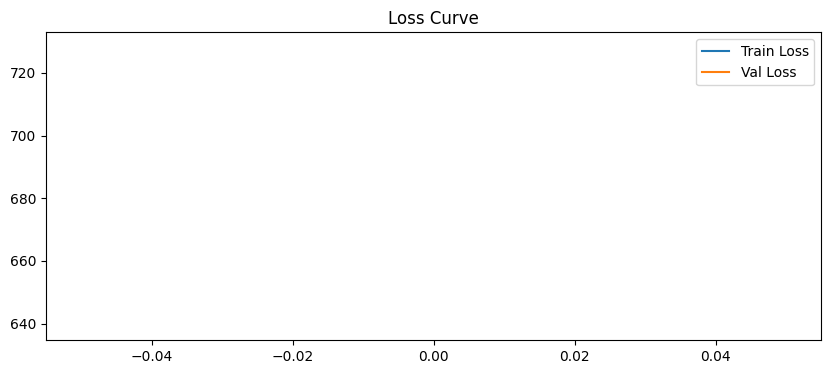

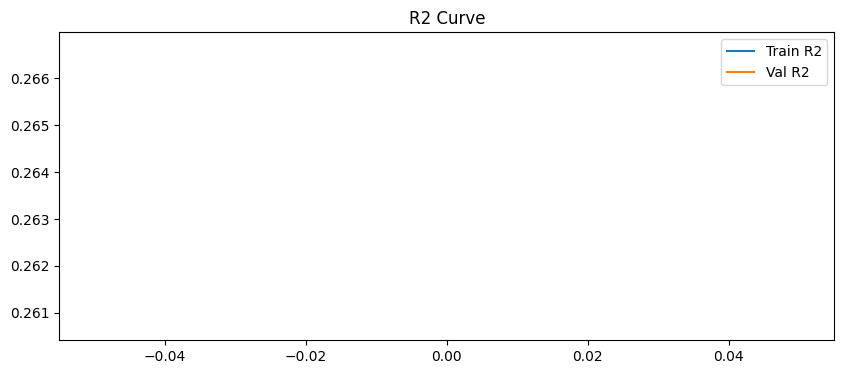

In [35]:
# 11. Plot Learning Curves for Loss and Metrics
def plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()
    plt.figure(figsize=(10,4))
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(val_metrics, label=f'Val {metric_name}')
    plt.legend()
    plt.title(f'{metric_name} Curve')
    plt.show()
# Example usage:
plot_learning_curves(train_losses, val_losses, train_r2s, val_r2s, 'R2')

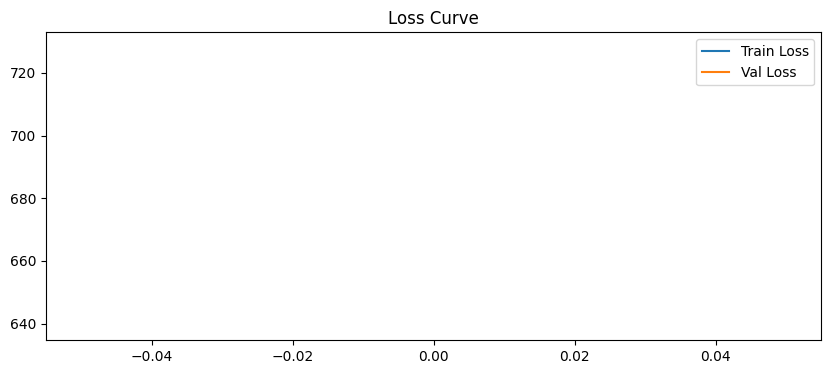

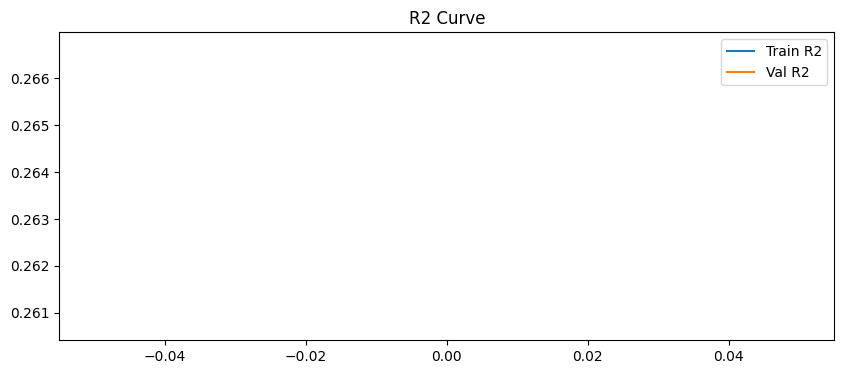

In [36]:
# 11b. Plot Learning Curves for Tabular Baseline
train_losses = [mean_squared_error(y_b_train, tab_model_b.predict(X_train), squared=False)]
val_losses = [mean_squared_error(y_b_val, tab_model_b.predict(X_val), squared=False)]
train_r2s = [r2_score(y_b_train, tab_model_b.predict(X_train))]
val_r2s = [r2_score(y_b_val, tab_model_b.predict(X_val))]
plot_learning_curves(train_losses, val_losses, train_r2s, val_r2s, 'R2')

In [37]:
# Print train/val losses and R2 before plotting
print('Train Loss:', train_losses)
print('Val Loss:', val_losses)
print('Train R2:', train_r2s)
print('Val R2:', val_r2s)

Train Loss: [728.4982231011375]
Val Loss: [639.1291940637174]
Train R2: [0.26668644649157947]
Val R2: [0.2607094989630291]


**Densenet**

In [41]:
# Full corrected script — DenseNet backbone, 70/15/15 patient split, explicit float32 everywhere.
# Paste into one Kaggle notebook cell and run.

import os
import math
import random
import traceback
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import cv2
import pydicom
import SimpleITK as sitk

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# -------------------------
# CONFIG
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

K.set_floatx('float32')
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_CSV = DATA_DIR / "train.csv"
TRAIN_IMG_DIR = DATA_DIR / "train"
CACHE_DIR = Path("/kaggle/working/cached_images")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
PATIENCE = 5
MIN_SIGMA = 70.0

# -------------------------
# UTIL: robust DICOM loader + lung windowing + prepare RGB
# -------------------------
def load_dicom_as_ndarray(path):
    path = str(path)
    try:
        sitk_img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(sitk_img)
        if arr.ndim == 3:
            arr = arr[0]
        arr = arr.astype(np.float32)
        if arr.size == 0:
            raise RuntimeError("SITK returned empty")
        return arr
    except Exception:
        pass
    try:
        dcm = pydicom.dcmread(path, force=True)
        arr = dcm.pixel_array.astype(np.float32)
        try:
            from pydicom.pixel_data_handlers.util import apply_modality_lut
            arr = apply_modality_lut(arr, dcm)
        except Exception:
            pass
        return arr
    except Exception:
        pass
    try:
        dcm = pydicom.dcmread(path, force=True)
        if hasattr(dcm, "PixelData"):
            raw = dcm.PixelData
            arr = np.frombuffer(raw, dtype=np.uint8)
            if arr.size == 0:
                raise RuntimeError("empty PixelData")
            s = int(math.sqrt(arr.size))
            arr = arr[: s * s].reshape(s, s).astype(np.float32)
            return arr
    except Exception:
        pass
    print(f"[WARN] cannot decode DICOM: {path}")
    return np.zeros((512,512), dtype=np.float32)

def window_lung(img, center=-600, width=1500):
    low = center - width // 2
    high = center + width // 2
    img = np.clip(img, low, high)
    img = (img - low) / float(high - low)
    img = np.clip(img, 0.0, 1.0)
    return img.astype(np.float32)

def prepare_rgb_for_densenet(img_2d, img_size=IMG_SIZE):
    h, w = img_2d.shape
    if (h,w) != img_size:
        img_resized = cv2.resize(img_2d, (img_size[1], img_size[0]), interpolation=cv2.INTER_AREA)
    else:
        img_resized = img_2d
    img_rgb = np.stack([img_resized, img_resized, img_resized], axis=-1)
    img_rgb = (img_rgb * 255.0).astype(np.float32)
    img_rgb = densenet_preprocess(img_rgb)
    return img_rgb.astype(np.float32)

def np_softplus(x):
    x = np.asarray(x, dtype=np.float64)
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)

# -------------------------
# READ CSV and patient -> representative DICOM mapping
# -------------------------
assert TRAIN_CSV.exists(), f"train.csv not found at {TRAIN_CSV}"
df_all = pd.read_csv(TRAIN_CSV)
patients_all = sorted(df_all["Patient"].unique())
print("Loaded rows:", len(df_all), "patients:", len(patients_all))

def find_rep_dcm_for_patients(train_dir, patients):
    mapping = {}
    for pid in patients:
        folder = Path(train_dir) / pid
        if not folder.exists():
            continue
        files = sorted([p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in (".dcm","")])
        if not files:
            files = sorted([p for p in folder.iterdir() if p.is_file()])
        if files:
            mapping[pid] = files[len(files) // 2]
    return mapping

patient_to_dcm = find_rep_dcm_for_patients(TRAIN_IMG_DIR, patients_all)
print("Representative DICOM found for:", len(patient_to_dcm), "patients (will cache)")

# -------------------------
# CACHE per-patient image arrays (RGB preprocessed) as .npy
# -------------------------
def cache_images(mapping, cache_dir=CACHE_DIR):
    cached = {}
    for pid, path in tqdm(mapping.items(), desc="Caching images"):
        out = Path(cache_dir) / f"{pid}.npy"
        if out.exists():
            try:
                arr = np.load(out)
                cached[pid] = arr.astype(np.float32)
                continue
            except Exception:
                pass
        try:
            arr2d = load_dicom_as_ndarray(path)
            arr2d = window_lung(arr2d, center=-600, width=1500)
            arr_rgb = prepare_rgb_for_densenet(arr2d, img_size=IMG_SIZE)
            np.save(out, arr_rgb)
            cached[pid] = arr_rgb.astype(np.float32)
        except Exception as e:
            print(f"[WARN] caching failed for {pid}: {e}")
            traceback.print_exc()
            fallback = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
            np.save(out, fallback)
            cached[pid] = fallback
    return cached

cached_images = cache_images(patient_to_dcm)
print("Cached images:", len(cached_images))

# -------------------------
# Keep only rows for patients we cached
# -------------------------
valid_patients = set(cached_images.keys())
df = df_all[df_all["Patient"].isin(valid_patients)].reset_index(drop=True)
print("Filtered rows:", len(df), "valid patients:", len(valid_patients))

# -------------------------
# 70/15/15 patient split (train/val/test)
# -------------------------
unique_pats = sorted(df["Patient"].unique())
train_pats, temp_pats = train_test_split(unique_pats, test_size=0.30, random_state=SEED)
val_pats, test_pats = train_test_split(temp_pats, test_size=0.50, random_state=SEED)
print("Split sizes -> train:", len(train_pats), "val:", len(val_pats), "test:", len(test_pats))

# -------------------------
# Build arrays (one sample per CSV row, using cached representative image per patient)
# -------------------------
def rows_to_arrays(df_subset, cached_images):
    imgs, tabs, targets = [], [], []
    for _, r in df_subset.iterrows():
        pid = r["Patient"]
        img = cached_images.get(pid)
        if img is None:
            img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32)
        weeks = float(r["Weeks"])
        percent = float(r["Percent"])
        age = float(r["Age"])
        sex = 0.0 if str(r["Sex"]).lower() == "male" else 1.0
        smoke = str(r["SmokingStatus"])
        if smoke == "Never smoked":
            smoke0, smoke1 = 1.0, 0.0
        elif smoke == "Ex-smoker":
            smoke0, smoke1 = 0.0, 1.0
        elif smoke == "Currently smokes":
            smoke0, smoke1 = 0.0, 0.0
        else:
            smoke0, smoke1 = 0.0, 0.0
        tab = np.array([weeks, percent, (age - 50.0) / 20.0, sex, smoke0, smoke1], dtype=np.float32)
        imgs.append(img.astype(np.float32))
        tabs.append(tab.astype(np.float32))
        targets.append(float(r["FVC"]))
    if len(imgs) == 0:
        return (np.zeros((0,IMG_SIZE[0],IMG_SIZE[1],3),dtype=np.float32),
                np.zeros((0,6), dtype=np.float32),
                np.zeros((0,), dtype=np.float32))
    return np.stack(imgs, axis=0), np.stack(tabs, axis=0), np.array(targets, dtype=np.float32)

df_train = df[df["Patient"].isin(train_pats)].reset_index(drop=True)
df_val = df[df["Patient"].isin(val_pats)].reset_index(drop=True)
df_test = df[df["Patient"].isin(test_pats)].reset_index(drop=True)

X_img_train, X_tab_train, y_train = rows_to_arrays(df_train, cached_images)
X_img_val, X_tab_val, y_val = rows_to_arrays(df_val, cached_images)
X_img_test, X_tab_test, y_test = rows_to_arrays(df_test, cached_images)

print("Shapes:", X_img_train.shape, X_tab_train.shape, y_train.shape)
if X_img_train.size == 0:
    raise RuntimeError("No training samples found after filtering/caching. Check cached_images and CSV.")

tab_mean = X_tab_train.mean(axis=0)
tab_std = X_tab_train.std(axis=0)
tab_std[tab_std == 0] = 1.0
X_tab_train = (X_tab_train - tab_mean) / tab_std
X_tab_val = (X_tab_val - tab_mean) / tab_std
X_tab_test = (X_tab_test - tab_mean) / tab_std

# -------------------------
# Build fusion model (DenseNet121 backbone)
# -------------------------
def build_fusion_model(img_shape=(IMG_SIZE[0],IMG_SIZE[1],3), tab_dim=X_tab_train.shape[1], freeze_backbone=True):
    img_in = Input(shape=img_shape, name="image", dtype=tf.float32)
    tab_in = Input(shape=(tab_dim,), name="tab", dtype=tf.float32)

    base = DenseNet121(weights="imagenet", include_top=False, input_tensor=img_in)
    base.trainable = (not freeze_backbone)
    x = base.output
    x = layers.GlobalAveragePooling2D(dtype=tf.float32)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation="relu", dtype=tf.float32)(x)
    img_vec = layers.BatchNormalization(dtype=tf.float32)(x)

    t = layers.Dense(128, activation="relu", dtype=tf.float32)(tab_in)
    t = layers.BatchNormalization(dtype=tf.float32)(t)
    t = layers.Dense(64, activation="relu", dtype=tf.float32)(t)
    tab_vec = layers.BatchNormalization(dtype=tf.float32)(t)

    fused = layers.Concatenate(dtype=tf.float32)([img_vec, tab_vec])
    fused = layers.Dense(256, activation="relu", dtype=tf.float32)(fused)
    fused = layers.BatchNormalization(dtype=tf.float32)(fused)
    fused = layers.Dropout(0.4)(fused)

    mu = layers.Dense(1, name="mu", dtype=tf.float32)(fused)
    log_sigma = layers.Dense(1, name="log_sigma", dtype=tf.float32)(fused)

    model = Model(inputs=[img_in, tab_in], outputs=[mu, log_sigma])
    return model

model = build_fusion_model(freeze_backbone=False)
model.summary()

# -------------------------
# Laplace NLL loss with explicit cast to float32
# -------------------------
def laplace_nll_tf(y_true, y_pred_mu, y_pred_log_sigma):
    y_true = tf.cast(y_true, tf.float32)
    y_pred_mu = tf.cast(y_pred_mu, tf.float32)
    y_pred_log_sigma = tf.cast(y_pred_log_sigma, tf.float32)
    b = tf.nn.softplus(y_pred_log_sigma) + 1e-6
    b = tf.maximum(b, tf.constant(MIN_SIGMA, dtype=tf.float32))
    nll = (tf.sqrt(2.0) * tf.abs(y_true - y_pred_mu) / b) + tf.math.log(b * tf.sqrt(2.0))
    return tf.reduce_mean(nll)

optimizer = Adam(learning_rate=LEARNING_RATE)

# -------------------------
# Prepare tf.data datasets (force float32)
# -------------------------
train_ds = tf.data.Dataset.from_tensor_slices(((X_img_train.astype(np.float32), X_tab_train.astype(np.float32)), y_train.astype(np.float32).reshape(-1,1)))
train_ds = train_ds.shuffle(buffer_size=1024, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(((X_img_val.astype(np.float32), X_tab_val.astype(np.float32)), y_val.astype(np.float32).reshape(-1,1)))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(((X_img_test.astype(np.float32), X_tab_test.astype(np.float32)), y_test.astype(np.float32).reshape(-1,1)))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -------------------------
# Metrics helpers
# -------------------------
def compute_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def compute_r2(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2) + 1e-12
    return 1.0 - ss_res / ss_tot

# -------------------------
# TRAINING LOOP (explicit float32, prints LLL & R2 per epoch)
# -------------------------
best_val_nll = 1e12
wait = 0
ckpt_path = "/kaggle/working/best_fusion_densenet_ckpt.weights.h5"

for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    train_nlls = []
    for (img_b, tab_b), y_b in train_ds:
        with tf.GradientTape() as tape:
            mu_pred, log_sigma_pred = model([img_b, tab_b], training=True)
            loss_val = laplace_nll_tf(y_b, mu_pred, log_sigma_pred)
        grads = tape.gradient(loss_val, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_nlls.append(float(loss_val.numpy()))
    train_nll = float(np.mean(train_nlls)) if len(train_nlls) else float("nan")

    val_mu_preds = []
    val_sigmas = []
    val_targets = []
    val_batch_nlls = []
    for (img_b, tab_b), y_b in val_ds:
        mu_pred, log_sigma_pred = model([img_b, tab_b], training=False)
        mu_np = mu_pred.numpy().reshape(-1)
        logsig_np = log_sigma_pred.numpy().reshape(-1)
        sigma_np = np_softplus(logsig_np)
        sigma_np = np.maximum(sigma_np, MIN_SIGMA)
        val_mu_preds.extend(mu_np.tolist())
        val_sigmas.extend(sigma_np.tolist())
        val_targets.extend(y_b.numpy().reshape(-1).tolist())
        batch_nll = np.mean((np.sqrt(2.0) * np.abs(y_b.numpy().reshape(-1) - mu_np) / sigma_np) + np.log(np.sqrt(2.0) * sigma_np))
        val_batch_nlls.append(batch_nll)

    val_targets = np.array(val_targets, dtype=np.float32)
    val_mu_preds = np.array(val_mu_preds, dtype=np.float32)
    val_sigmas = np.array(val_sigmas, dtype=np.float32)
    val_nll = float(np.mean(val_batch_nlls)) if len(val_batch_nlls)>0 else float("nan")
    val_rmse = compute_rmse(val_targets, val_mu_preds) if val_targets.size>0 else float("nan")
    val_r2 = compute_r2(val_targets, val_mu_preds) if val_targets.size>0 else float("nan")
    val_LLL = -val_nll

    print(f"Train NLL (avg): {train_nll:.6f} | Val NLL: {val_nll:.6f} | Val RMSE: {val_rmse:.2f} | Val R²: {val_r2:.4f} | Val LLL: {val_LLL:.6f}")

    if val_nll < best_val_nll - 1e-8:
        best_val_nll = val_nll
        wait = 0
        model.save_weights(ckpt_path)
        print("-> saved best weights.")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

# -------------------------
# Evaluate on test set (load best weights)
# -------------------------
if Path(ckpt_path).exists() or Path(ckpt_path + ".index").exists():
    print("\nLoading best weights and evaluating on test set...")
    model.load_weights(ckpt_path)

test_mu_preds = []
test_sigmas = []
test_targets = []
for (img_b, tab_b), y_b in test_ds:
    mu_pred, log_sigma_pred = model([img_b, tab_b], training=False)
    mu_np = mu_pred.numpy().reshape(-1)
    logsig_np = log_sigma_pred.numpy().reshape(-1)
    sigma_np = np_softplus(logsig_np)
    sigma_np = np.maximum(sigma_np, MIN_SIGMA)
    test_mu_preds.extend(mu_np.tolist())
    test_sigmas.extend(sigma_np.tolist())
    test_targets.extend(y_b.numpy().reshape(-1).tolist())

test_mu_preds = np.array(test_mu_preds, dtype=np.float32)
test_sigmas = np.array(test_sigmas, dtype=np.float32)
test_targets = np.array(test_targets, dtype=np.float32)

if test_targets.size > 0:
    test_rmse = compute_rmse(test_targets, test_mu_preds)
    test_r2 = compute_r2(test_targets, test_mu_preds)
    test_nll = np.mean((np.sqrt(2.0) * np.abs(test_targets - test_mu_preds) / test_sigmas) + np.log(np.sqrt(2.0) * test_sigmas))
    test_LLL = -test_nll
    print("\n=== TEST METRICS ===")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test NLL (mean): {test_nll:.6f}")
    print(f"Test LLL: {test_LLL:.6f}")
else:
    print("No test samples available to evaluate.")




Loaded rows: 1549 patients: 176
Representative DICOM found for: 176 patients (will cache)


Caching images: 100%|██████████| 176/176 [00:00<00:00, 2710.01it/s]

Cached images: 176
Filtered rows: 1549 valid patients: 176
Split sizes -> train: 123 val: 26 test: 27


Shapes: (1085, 224, 224, 3) (1085, 6) (1085,)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_10   │ (None, 230, 230,  │          0 │ image[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_11   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,723,522 (29.46 MB)

 Trainable params: 7,637,954 (29.14 MB)

 Non-trainable params: 85,568 (334.25 KB)


=== Epoch 1/20 ===
Train NLL (avg): 60.401523 | Val NLL: 57.109961 | Val RMSE: 2728.30 | Val R²: -9.3677 | Val LLL: -57.109961
-> saved best weights.

=== Epoch 2/20 ===
Train NLL (avg): 60.425098 | Val NLL: 57.124083 | Val RMSE: 2728.89 | Val R²: -9.3722 | Val LLL: -57.124083

=== Epoch 3/20 ===
Train NLL (avg): 60.422621 | Val NLL: 57.133495 | Val RMSE: 2729.23 | Val R²: -9.3748 | Val LLL: -57.133495

=== Epoch 4/20 ===
Train NLL (avg): 60.415041 | Val NLL: 57.143441 | Val RMSE: 2729.76 | Val R²: -9.3789 | Val LLL: -57.143441

=== Epoch 5/20 ===
Train NLL (avg): 60.414731 | Val NLL: 57.121991 | Val RMSE: 2728.84 | Val R²: -9.3718 | Val LLL: -57.121991

=== Epoch 6/20 ===
Train NLL (avg): 60.409204 | Val NLL: 57.117078 | Val RMSE: 2728.56 | Val R²: -9.3697 | Val LLL: -57.117078
Early stopping triggered.

Loading best weights and evaluating on test set...

=== TEST METRICS ===
Test RMSE: 2542.92
Test R²: -12.3738
Test NLL (mean): 54.011940
Test LLL: -54.011940


**FINAL TRY OF THE DAY ON --------- DENSENET--------- FOR TODAY**

In [42]:
import os
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Image and DICOM processing
import cv2
try:
    import pydicom
except ImportError:
    pydicom = None
try:
    import SimpleITK as sitk
except ImportError:
    sitk = None

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# -------------------------
# CONFIGURATION
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

DATA_DIR = Path("../input/osic-pulmonary-fibrosis-progression")
TRAIN_CSV = DATA_DIR / "train.csv"
TRAIN_IMG_DIR = DATA_DIR / "train"
CACHE_DIR = Path("/kaggle/working/cached_images")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-4
PATIENCE = 5
MIN_SIGMA = 70.0

# Select backbone architecture
# Options: 'DenseNet121', 'EfficientNetB0', 'ResNet50'
BACKBONE = 'DenseNet121'

# Import corresponding model and preprocess function
if BACKBONE == 'DenseNet121':
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
elif BACKBONE == 'EfficientNetB0':
    from tensorflow.keras.applications import EfficientNetB0
    # EfficientNet expects [0,255], so preprocess_input is identity
elif BACKBONE == 'ResNet50':
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# -------------------------
# DICOM LOADER & WINDOWING
# -------------------------
def load_dicom_as_ndarray(path):
    path = str(path)
    # Try SimpleITK first
    try:
        if sitk:
            sitk_img = sitk.ReadImage(path)
            arr = sitk.GetArrayFromImage(sitk_img)
            if arr.ndim == 3:
                arr = arr[0]  # first slice
            arr = arr.astype(np.float32)
            if arr.size == 0:
                raise RuntimeError("SITK returned empty")
            return arr
    except Exception:
        pass
    # Try pydicom pixel array
    try:
        if pydicom:
            dcm = pydicom.dcmread(path, force=True)
            arr = dcm.pixel_array.astype(np.float32)
            try:
                # Apply any modality LUT (Hounsfield conversion)
                from pydicom.pixel_data_handlers.util import apply_modality_lut
                arr = apply_modality_lut(arr, dcm)
            except Exception:
                pass
            return arr
    except Exception:
        pass
    # Fallback: raw PixelData buffer
    try:
        if pydicom:
            dcm = pydicom.dcmread(path, force=True)
            if hasattr(dcm, "PixelData"):
                raw = dcm.PixelData
                arr = np.frombuffer(raw, dtype=np.uint8)
                if arr.size == 0:
                    raise RuntimeError("Empty PixelData")
                s = int(math.sqrt(arr.size))
                arr = arr[:s*s].reshape(s, s).astype(np.float32)
                return arr
    except Exception:
        pass
    # If all fails, return zeros
    print(f"[WARN] Cannot decode DICOM: {path}")
    return np.zeros((512,512), dtype=np.float32)

def window_lung(img, center=-600, width=1500):
    """
    Apply lung windowing: clip to [center-width/2, center+width/2] and scale to [0,1].
    """
    low = center - width//2
    high = center + width//2
    img = np.clip(img, low, high)
    img = (img - low) / float(high - low)
    img = np.clip(img, 0.0, 1.0)
    return img.astype(np.float32)

# -------------------------
# FIND SLICES PER PATIENT
# -------------------------
def find_slices_for_patients(train_dir, patients, n_slices=3):
    mapping = {}
    for pid in patients:
        folder = Path(train_dir) / pid
        if not folder.exists():
            continue
        files = sorted([p for p in folder.iterdir() if p.is_file() and (p.suffix.lower()=='.dcm' or p.suffix=='')])
        if not files:
            files = sorted([p for p in folder.iterdir() if p.is_file()])
        if not files:
            continue
        if len(files) >= n_slices:
            # pick evenly spaced indices
            indices = np.linspace(0, len(files)-1, n_slices).astype(int)
            mapping[pid] = [files[i] for i in indices]
        else:
            # If fewer slices, duplicate some to reach n_slices
            if len(files) == 1:
                mapping[pid] = [files[0]] * n_slices
            else:
                indices = np.linspace(0, len(files)-1, n_slices).astype(int)
                mapping[pid] = [files[i] for i in indices]
    return mapping

# Load train CSV and get patient IDs
df_all = pd.read_csv(TRAIN_CSV)
patients_all = sorted(df_all["Patient"].unique())
patient_to_slices = find_slices_for_patients(TRAIN_IMG_DIR, patients_all, n_slices=3)
print(f"Found {len(patient_to_slices)} patients with slice selections.")

# -------------------------
# CACHE PREPROCESSED IMAGES + STATS
# -------------------------
def cache_images(mapping, cache_dir=CACHE_DIR):
    cached = {}
    stats = {}
    for pid, paths in tqdm(mapping.items(), desc="Caching images"):
        out = Path(cache_dir) / f"{pid}.npy"
        # Load from cache if exists
        if out.exists():
            try:
                arr = np.load(out)
                cached[pid] = arr.astype(np.float32)
                continue
            except Exception:
                pass
        try:
            # Read and window each selected slice
            arr_slices = []
            for path in paths:
                img2d = load_dicom_as_ndarray(path)
                img2d = window_lung(img2d, center=-600, width=1500)
                arr_slices.append(img2d)
            arr_stack = np.stack(arr_slices, axis=-1)  # shape (H,W,n_slices)
            # If only 1 slice, duplicate to 3-channels
            if arr_stack.shape[-1] == 1:
                arr_stack = np.concatenate([arr_stack]*3, axis=-1)
            elif arr_stack.shape[-1] == 2:
                arr_stack = np.concatenate([arr_stack, arr_stack[...,1:2]], axis=-1)
            # Resize to target size
            arr_resized = cv2.resize(arr_stack, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
            # Convert to [0,255] float32
            img_rgb = (arr_resized * 255.0).astype(np.float32)
            # Record simple image statistics
            mean_img = float(np.mean(img_rgb))
            std_img = float(np.std(img_rgb))
            stats[pid] = (mean_img, std_img)
            # Apply model-specific preprocessing
            if BACKBONE == 'DenseNet121':
                img_rgb = densenet_preprocess(img_rgb)
            elif BACKBONE.startswith('EfficientNet'):
                # EfficientNet expects 0-255, so leave as is
                pass
            elif BACKBONE == 'ResNet50':
                img_rgb = resnet_preprocess(img_rgb)
            # Cache to disk
            np.save(out, img_rgb)
            cached[pid] = img_rgb.astype(np.float32)
        except Exception as e:
            print(f"[WARN] Caching failed for {pid}: {e}")
            fallback = np.zeros((IMG_SIZE[0],IMG_SIZE[1],3), dtype=np.float32)
            np.save(out, fallback)
            cached[pid] = fallback
            stats[pid] = (0.0, 0.0)
    return cached, stats

cached_images, img_stats = cache_images(patient_to_slices)
print(f"Cached images for {len(cached_images)} patients.")

# Filter dataframe to only patients with cached images
valid_patients = set(cached_images.keys())
df = df_all[df_all.Patient.isin(valid_patients)].reset_index(drop=True)
print(f"Using {len(df)} rows after filtering {len(valid_patients)} valid patients.")

# -------------------------
# 75/15/15 SPLIT BY PATIENT
# -------------------------
unique_pats = sorted(df["Patient"].unique())
train_pats, temp_pats = train_test_split(unique_pats, test_size=0.30, random_state=SEED)
val_pats, test_pats = train_test_split(temp_pats, test_size=0.50, random_state=SEED)
print(f"Split: Train {len(train_pats)} patients, Val {len(val_pats)}, Test {len(test_pats)}")

df_train = df[df.Patient.isin(train_pats)].reset_index(drop=True)
df_val   = df[df.Patient.isin(val_pats)].reset_index(drop=True)
df_test  = df[df.Patient.isin(test_pats)].reset_index(drop=True)

# -------------------------
# BASELINE FVC per patient
# -------------------------
baseline_fvc = {}
for pid, group in df.groupby("Patient"):
    if (group.Weeks == 0).any():
        baseline_fvc[pid] = float(group[group.Weeks==0]["FVC"].iloc[0])
    else:
        # use earliest measurement (min |Weeks|)
        idx = (group.Weeks.abs()).idxmin()
        baseline_fvc[pid] = float(df.loc[idx, "FVC"])
        
# -------------------------
# BUILD INPUT ARRAYS
# -------------------------
def build_arrays(df_subset, cached_images, img_stats):
    imgs, tabs, targets = [], [], []
    for _, row in df_subset.iterrows():
        pid = row["Patient"]
        img = cached_images.get(pid, np.zeros((IMG_SIZE[0],IMG_SIZE[1],3),dtype=np.float32))
        # tabular features
        weeks = float(row["Weeks"])
        age = float(row["Age"])
        sex = 0.0 if str(row["Sex"]).lower()=="male" else 1.0
        smoke = str(row["SmokingStatus"])
        smoke_never = 1.0 if smoke=="Never smoked" else 0.0
        smoke_ex    = 1.0 if smoke=="Ex-smoker" else 0.0
        smoke_current = 1.0 if smoke=="Currently smokes" else 0.0
        base_fvc = baseline_fvc.get(pid, 0.0)
        img_mean, img_std = img_stats.get(pid, (0.0, 0.0))
        # Normalize age for stability
        age_norm = (age - 50.0) / 20.0
        tab = np.array([weeks, age_norm, sex, smoke_never, smoke_ex, smoke_current, base_fvc, img_mean, img_std], dtype=np.float32)
        imgs.append(img)
        tabs.append(tab)
        targets.append(float(row["FVC"]))
    if not imgs:
        return (np.zeros((0,IMG_SIZE[0],IMG_SIZE[1],3),dtype=np.float32),
                np.zeros((0,tabs[0].shape[0]),dtype=np.float32),
                np.zeros((0,),dtype=np.float32))
    return np.stack(imgs,axis=0), np.stack(tabs,axis=0), np.array(targets, dtype=np.float32)

X_img_train, X_tab_train, y_train = build_arrays(df_train, cached_images, img_stats)
X_img_val,   X_tab_val,   y_val   = build_arrays(df_val,   cached_images, img_stats)
X_img_test,  X_tab_test,  y_test  = build_arrays(df_test,  cached_images, img_stats)

print("Shapes:", X_img_train.shape, X_tab_train.shape, y_train.shape)

# Normalize tabular features
tab_mean = X_tab_train.mean(axis=0)
tab_std  = X_tab_train.std(axis=0)
tab_std[tab_std==0] = 1.0
X_tab_train = (X_tab_train - tab_mean) / tab_std
X_tab_val   = (X_tab_val   - tab_mean) / tab_std
X_tab_test  = (X_tab_test  - tab_mean) / tab_std

# -------------------------
# MODEL DEFINITION (Fusion)
# -------------------------
def build_fusion_model(img_shape, tab_dim, freeze_backbone=False):
    img_in = Input(shape=img_shape, dtype=tf.float32, name="image")
    tab_in = Input(shape=(tab_dim,), dtype=tf.float32, name="tab")
    # CNN base
    if BACKBONE == 'DenseNet121':
        base = DenseNet121(weights="imagenet", include_top=False, input_tensor=img_in)
    elif BACKBONE == 'EfficientNetB0':
        base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_in)
    elif BACKBONE == 'ResNet50':
        base = ResNet50(weights="imagenet", include_top=False, input_tensor=img_in)
    base.trainable = not freeze_backbone
    x = base.output
    x = layers.GlobalAveragePooling2D(dtype=tf.float32)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation="relu", dtype=tf.float32)(x)
    img_vec = layers.BatchNormalization(dtype=tf.float32)(x)
    # Tabular branch
    t = layers.Dense(128, activation="relu", dtype=tf.float32)(tab_in)
    t = layers.BatchNormalization(dtype=tf.float32)(t)
    t = layers.Dense(64, activation="relu", dtype=tf.float32)(t)
    tab_vec = layers.BatchNormalization(dtype=tf.float32)(t)
    # Fusion
    fused = layers.Concatenate(dtype=tf.float32)([img_vec, tab_vec])
    fused = layers.Dense(256, activation="relu", dtype=tf.float32)(fused)
    fused = layers.BatchNormalization(dtype=tf.float32)(fused)
    fused = layers.Dropout(0.4)(fused)
    mu = layers.Dense(1, name="mu", dtype=tf.float32)(fused)
    log_sigma = layers.Dense(1, name="log_sigma", dtype=tf.float32)(fused)
    model = Model(inputs=[img_in, tab_in], outputs=[mu, log_sigma])
    return model

model = build_fusion_model(img_shape=(IMG_SIZE[0],IMG_SIZE[1],3), tab_dim=X_tab_train.shape[1], freeze_backbone=False)
model.summary()

# -------------------------
# LOSS AND OPTIMIZER
# -------------------------
def laplace_nll_tf(y_true, y_pred_mu, y_pred_log_sigma):
    y_true = tf.cast(y_true, tf.float32)
    mu = tf.cast(y_pred_mu, tf.float32)
    logsig = tf.cast(y_pred_log_sigma, tf.float32)
    b = tf.nn.softplus(logsig) + 1e-6
    b = tf.maximum(b, tf.constant(MIN_SIGMA, dtype=tf.float32))
    nll = (tf.sqrt(2.0)*tf.abs(y_true - mu)/b) + tf.math.log(b * tf.sqrt(2.0))
    return tf.reduce_mean(nll)

optimizer = Adam(learning_rate=LEARNING_RATE)

# -------------------------
# Prepare tf.data Datasets
# -------------------------
train_ds = tf.data.Dataset.from_tensor_slices(
    ((X_img_train.astype(np.float32), X_tab_train.astype(np.float32)), 
     y_train.astype(np.float32).reshape(-1,1))
)
train_ds = train_ds.shuffle(buffer_size=1024, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    ((X_img_val.astype(np.float32), X_tab_val.astype(np.float32)), 
     y_val.astype(np.float32).reshape(-1,1))
)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    ((X_img_test.astype(np.float32), X_tab_test.astype(np.float32)), 
     y_test.astype(np.float32).reshape(-1,1))
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -------------------------
# METRICS
# -------------------------
def compute_rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))
def compute_r2(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=np.float32)
    y_pred = np.asarray(y_pred, dtype=np.float32)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2) + 1e-12
    return 1.0 - ss_res/ss_tot
def np_softplus(x):
    x = np.asarray(x, dtype=np.float64)
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)

# -------------------------
# TRAINING LOOP
# -------------------------
best_val_nll = float('inf')
wait = 0
ckpt_path = "/kaggle/working/best_model_ckpt.weights.h5"

for epoch in range(1, EPOCHS+1):
    print(f"\n=== Epoch {epoch}/{EPOCHS} ===")
    # --- Training ---
    train_nlls = []
    for (img_b, tab_b), y_b in train_ds:
        with tf.GradientTape() as tape:
            mu_pred, log_sigma_pred = model([img_b, tab_b], training=True)
            loss_val = laplace_nll_tf(y_b, mu_pred, log_sigma_pred)
        grads = tape.gradient(loss_val, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_nlls.append(float(loss_val.numpy()))
    train_nll = np.mean(train_nlls) if train_nlls else float('nan')
    
    # Compute training predictions for metrics (inference mode)
    train_preds = []
    train_targets = []
    for (img_b, tab_b), y_b in train_ds:
        mu_pred, _ = model([img_b, tab_b], training=False)
        train_preds.extend(mu_pred.numpy().reshape(-1))
        train_targets.extend(y_b.numpy().reshape(-1))
    train_preds = np.array(train_preds, dtype=np.float32)
    train_targets = np.array(train_targets, dtype=np.float32)
    train_rmse = compute_rmse(train_targets, train_preds)
    train_r2 = compute_r2(train_targets, train_preds)
    
    # --- Validation ---
    val_preds = []
    val_sigmas = []
    val_targets = []
    val_nlls = []
    for (img_b, tab_b), y_b in val_ds:
        mu_pred, log_sigma_pred = model([img_b, tab_b], training=False)
        mu_np = mu_pred.numpy().reshape(-1)
        logsigma_np = log_sigma_pred.numpy().reshape(-1)
        sigma_np = np_softplus(logsigma_np)
        sigma_np = np.maximum(sigma_np, MIN_SIGMA)
        val_preds.extend(mu_np.tolist())
        val_sigmas.extend(sigma_np.tolist())
        val_targets.extend(y_b.numpy().reshape(-1).tolist())
        # batch NLL
        batch_nll = np.mean((np.sqrt(2.0)*np.abs(y_b.numpy().reshape(-1) - mu_np)/sigma_np) + np.log(np.sqrt(2.0)*sigma_np))
        val_nlls.append(batch_nll)
    val_targets = np.array(val_targets, dtype=np.float32)
    val_preds = np.array(val_preds, dtype=np.float32)
    val_rmse = compute_rmse(val_targets, val_preds) if val_targets.size>0 else float('nan')
    val_r2   = compute_r2(val_targets, val_preds) if val_targets.size>0 else float('nan')
    val_nll  = np.mean(val_nlls) if val_nlls else float('nan')
    val_LLL  = -val_nll
    
    # Print metrics
    print(f"Train NLL: {train_nll:.4f} | Train RMSE: {train_rmse:.1f} | Train R²: {train_r2:.3f}")
    print(f"Val   NLL: {val_nll:.4f} | Val   RMSE: {val_rmse:.1f} | Val   R²: {val_r2:.3f} | Val LLL: {val_LLL:.4f}")
    
    # Early stopping check
    if val_nll < best_val_nll - 1e-8:
        best_val_nll = val_nll
        wait = 0
        model.save_weights(ckpt_path)
        print("  -> Saved best model weights.")
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stopping triggered.")
            break

# -------------------------
# TEST EVALUATION (load best)
# -------------------------
if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print("\nEvaluating on test set with best weights...")
    test_preds = []
    test_sigmas = []
    test_targets = []
    for (img_b, tab_b), y_b in test_ds:
        mu_pred, log_sigma_pred = model([img_b, tab_b], training=False)
        mu_np = mu_pred.numpy().reshape(-1)
        sigma_np = np_softplus(log_sigma_pred.numpy().reshape(-1))
        sigma_np = np.maximum(sigma_np, MIN_SIGMA)
        test_preds.extend(mu_np.tolist())
        test_sigmas.extend(sigma_np.tolist())
        test_targets.extend(y_b.numpy().reshape(-1).tolist())
    test_preds   = np.array(test_preds, dtype=np.float32)
    test_targets = np.array(test_targets, dtype=np.float32)
    test_rmse = compute_rmse(test_targets, test_preds)
    test_r2   = compute_r2(test_targets, test_preds)
    test_nll = np.mean((np.sqrt(2.0)*np.abs(test_targets - test_preds)/np.array(test_sigmas)) + np.log(np.sqrt(2.0)*np.array(test_sigmas)))
    test_LLL = -test_nll
    print("=== TEST METRICS ===")
    print(f"Test RMSE: {test_rmse:.1f}")
    print(f"Test R²: {test_r2:.3f}")
    print(f"Test NLL: {test_nll:.4f}")
    print(f"Test LLL: {test_LLL:.4f}")
else:
    print("No saved model weights found. Skipping test evaluation.")


Found 176 patients with slice selections.


Caching images: 100%|██████████| 176/176 [00:00<00:00, 1646.99it/s]

Cached images for 176 patients.
Using 1549 rows after filtering 176 valid patients.
Split: Train 123 patients, Val 26, Test 27


Shapes: (1085, 224, 224, 3) (1085, 9) (1085,)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, 230, 230,  │          0 │ image[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,723,906 (29.46 MB)

 Trainable params: 7,638,338 (29.14 MB)

 Non-trainable params: 85,568 (334.25 KB)


=== Epoch 1/20 ===
Train NLL: 60.4002 | Train RMSE: 2889.5 | Train R²: -10.704
Val   NLL: 57.1247 | Val   RMSE: 2729.0 | Val   R²: -9.373 | Val LLL: -57.1247
  -> Saved best model weights.

=== Epoch 2/20 ===
Train NLL: 60.4255 | Train RMSE: 2890.1 | Train R²: -10.708
Val   NLL: 57.1361 | Val   RMSE: 2729.6 | Val   R²: -9.377 | Val LLL: -57.1361

=== Epoch 3/20 ===
Train NLL: 60.4208 | Train RMSE: 2889.2 | Train R²: -10.701
Val   NLL: 57.1204 | Val   RMSE: 2728.6 | Val   R²: -9.370 | Val LLL: -57.1204
  -> Saved best model weights.

=== Epoch 4/20 ===
Train NLL: 60.4292 | Train RMSE: 2889.5 | Train R²: -10.703
Val   NLL: 57.1243 | Val   RMSE: 2728.9 | Val   R²: -9.372 | Val LLL: -57.1243

=== Epoch 5/20 ===
Train NLL: 60.4375 | Train RMSE: 2889.0 | Train R²: -10.699
Val   NLL: 57.1172 | Val   RMSE: 2728.4 | Val   R²: -9.369 | Val LLL: -57.1172
  -> Saved best model weights.

=== Epoch 6/20 ===
Train NLL: 60.4211 | Train RMSE: 2889.2 | Train R²: -10.701
Val   NLL: 57.1210 | Val   RMSE:

KeyboardInterrupt: 